<a href="https://colab.research.google.com/github/seansothey/MyProject/blob/master/grabcut_maskrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation with Mask R-CNN, GrabCut, and OpenCV

### Install the necessary packages

In [1]:
!pip install opencv-python==4.2.0.34

     |████████████████████████████████| 28.2MB 111kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


### Download the code zip file

In [2]:
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/grabcut-maskrcnn/grabcut-maskrcnn.zip
!unzip -qq grabcut-maskrcnn.zip
%cd grabcut-maskrcnn

--2020-11-03 06:31:02--  https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/grabcut-maskrcnn/grabcut-maskrcnn.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.212.112
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.212.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59375641 (57M) [application/zip]
Saving to: ‘grabcut-maskrcnn.zip’

grabcut-maskrcnn.zi 100%[===================>]  56.62M  67.9MB/s    in 0.8s    

2020-11-03 06:31:03 (67.9 MB/s) - ‘grabcut-maskrcnn.zip’ saved [59375641/59375641]

/content/grabcut-maskrcnn


### Import Packages

In [3]:
# import the necessary packages
from matplotlib import pyplot as plt
import numpy as np
import argparse
import imutils
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [4]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Our driver script

In [5]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-m", "--mask-rcnn", required=True,
#	help="base path to mask-rcnn directory")
#ap.add_argument("-i", "--image", required=True,
#	help="path to input image")
#ap.add_argument("-c", "--confidence", type=float, default=0.5,
#	help="minimum probability to filter weak detections")
#ap.add_argument("-t", "--threshold", type=float, default=0.3,
#	help="minimum threshold for pixel-wise mask segmentation")
#ap.add_argument("-u", "--use-gpu", type=bool, default=0,
#	help="boolean indicating if CUDA GPU should be used")
#ap.add_argument("-e", "--iter", type=int, default=10,
#	help="# of GrabCut iterations (larger value => slower runtime)")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"mask_rcnn": "mask-rcnn-coco",
	"image": "example.jpg",
	"confidence": 0.5,
	"threshold": 0.3,
	"use_gpu": 0,
	"iter": 10
}

In [6]:
# load the COCO class labels our Mask R-CNN was trained on
labelsPath = os.path.sep.join([args["mask_rcnn"],
	"object_detection_classes_coco.txt"])
LABELS = open(labelsPath).read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

In [7]:
# derive the paths to the Mask R-CNN weights and model configuration
weightsPath = os.path.sep.join([args["mask_rcnn"],
	"frozen_inference_graph.pb"])
configPath = os.path.sep.join([args["mask_rcnn"],
	"mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"])

# load our Mask R-CNN trained on the COCO dataset (90 classes)
# from disk
print("[INFO] loading Mask R-CNN from disk...")
net = cv2.dnn.readNetFromTensorflow(weightsPath, configPath)

# check if we are going to use GPU
if args["use_gpu"]:
	# set CUDA as the preferable backend and target
	print("[INFO] setting preferable backend and target to CUDA...")
	net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
	net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

[INFO] loading Mask R-CNN from disk...


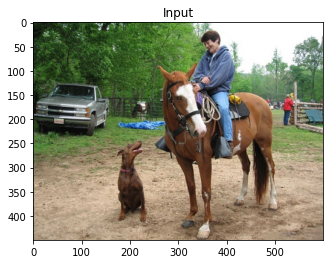

In [8]:
# load our input image from disk and display it to our screen
image = cv2.imread(args["image"])
image = imutils.resize(image, width=600)
plt_imshow("Input", image)

# construct a blob from the input image and then perform a
# forward pass of the Mask R-CNN, giving us (1) the bounding box
# coordinates of the objects in the image along with (2) the
# pixel-wise segmentation for each specific object
blob = cv2.dnn.blobFromImage(image, swapRB=True, crop=False)
net.setInput(blob)
(boxes, masks) = net.forward(["detection_out_final",
	"detection_masks"])

[INFO] showing output for 'horse'...


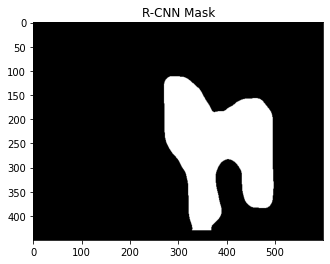

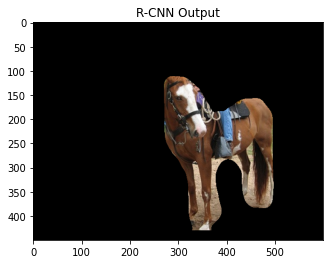

[INFO] applying GrabCut to 'horse' ROI...


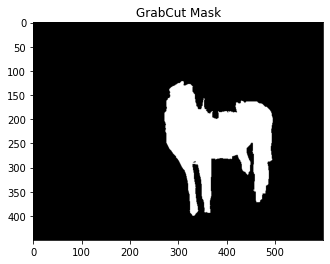

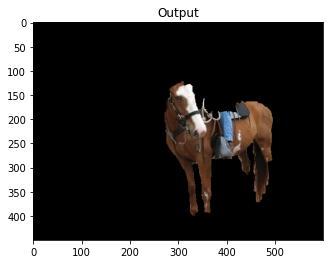

[INFO] showing output for 'person'...


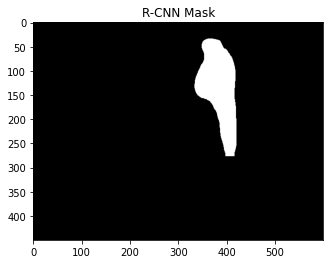

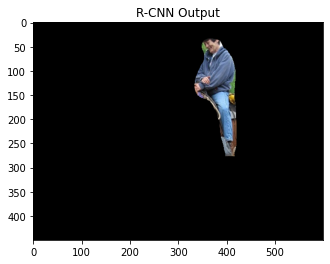

[INFO] applying GrabCut to 'person' ROI...


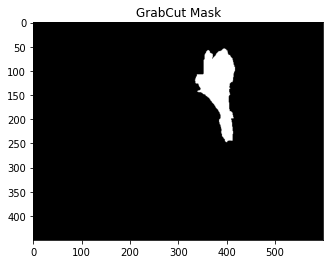

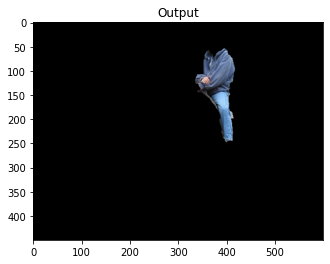

[INFO] showing output for 'dog'...


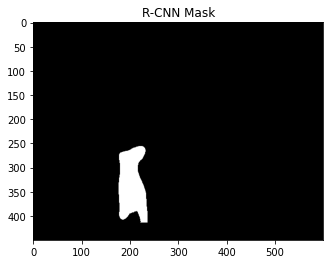

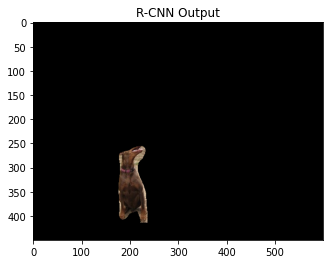

[INFO] applying GrabCut to 'dog' ROI...


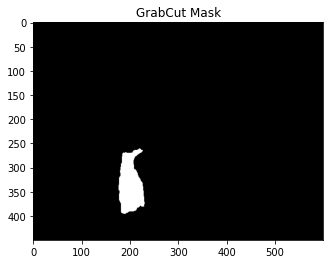

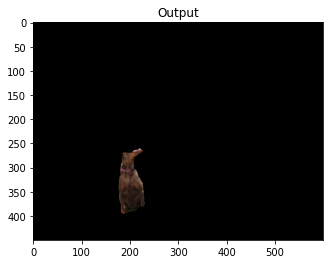

[INFO] showing output for 'truck'...


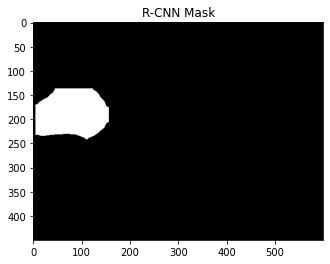

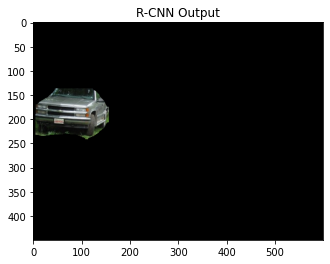

[INFO] applying GrabCut to 'truck' ROI...


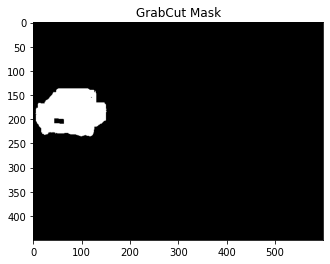

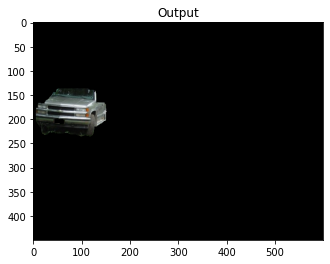

[INFO] showing output for 'person'...


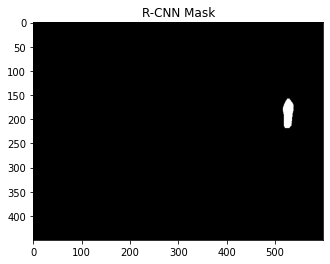

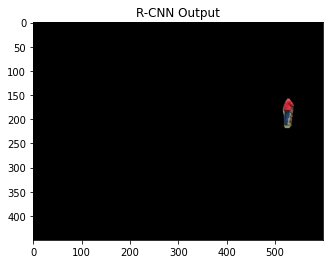

[INFO] applying GrabCut to 'person' ROI...


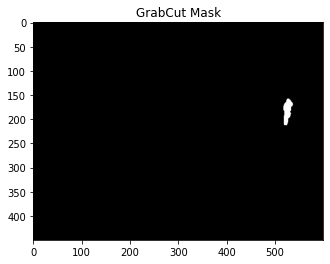

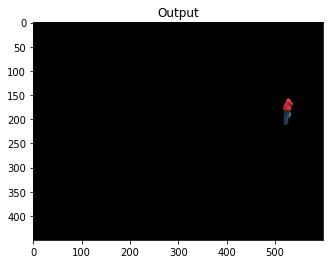

In [9]:
# loop over the number of detected objects
for i in range(0, boxes.shape[2]):
	# extract the class ID of the detection along with the
	# confidence (i.e., probability) associated with the
	# prediction
	classID = int(boxes[0, 0, i, 1])
	confidence = boxes[0, 0, i, 2]

	# filter out weak predictions by ensuring the detected
	# probability is greater than the minimum probability
	if confidence > args["confidence"]:
		# show the class label
		print("[INFO] showing output for '{}'...".format(
			LABELS[classID]))

		# scale the bounding box coordinates back relative to the
		# size of the image and then compute the width and the
		# height of the bounding box
		(H, W) = image.shape[:2]
		box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
		(startX, startY, endX, endY) = box.astype("int")
		boxW = endX - startX
		boxH = endY - startY

		# extract the pixel-wise segmentation for the object, resize
		# the mask such that it's the same dimensions as the bounding
		# box, and then finally threshold to create a *binary* mask
		mask = masks[i, classID]
		mask = cv2.resize(mask, (boxW, boxH),
			interpolation=cv2.INTER_CUBIC)
		mask = (mask > args["threshold"]).astype("uint8") * 255

		# allocate a memory for our output Mask R-CNN mask and store
		# the predicted Mask R-CNN mask in the GrabCut mask
		rcnnMask = np.zeros(image.shape[:2], dtype="uint8")
		rcnnMask[startY:endY, startX:endX] = mask

		# apply a bitwise AND to the input image to show the output
		# of applying the Mask R-CNN mask to the image
		rcnnOutput = cv2.bitwise_and(image, image, mask=rcnnMask)

		# show the output of the Mask R-CNN and bitwise AND operation
		plt_imshow("R-CNN Mask", rcnnMask)
		plt_imshow("R-CNN Output", rcnnOutput)
  
  		# clone the Mask R-CNN mask (so we can use it when applying
		# GrabCut) and set any mask values greater than zero to be
		# "probable foreground" (otherwise they are "definite
		# background")
		gcMask = rcnnMask.copy()
		gcMask[gcMask > 0] = cv2.GC_PR_FGD
		gcMask[gcMask == 0] = cv2.GC_BGD

		# allocate memory for two arrays that the GrabCut algorithm
		# internally uses when segmenting the foreground from the
		# background and then apply GrabCut using the mask
		# segmentation method
		print("[INFO] applying GrabCut to '{}' ROI...".format(
			LABELS[classID]))
		fgModel = np.zeros((1, 65), dtype="float")
		bgModel = np.zeros((1, 65), dtype="float")
		(gcMask, bgModel, fgModel) = cv2.grabCut(image, gcMask,
			None, bgModel, fgModel, iterCount=args["iter"],
			mode=cv2.GC_INIT_WITH_MASK)
  
  		# set all definite background and probable background pixels
		# to 0 while definite foreground and probable foreground
		# pixels are set to 1, then scale the mask from the range
		# [0, 1] to [0, 255]
		outputMask = np.where(
			(gcMask == cv2.GC_BGD) | (gcMask == cv2.GC_PR_BGD), 0, 1)
		outputMask = (outputMask * 255).astype("uint8")

		# apply a bitwise AND to the image using our mask generated
		# by GrabCut to generate our final output image
		output = cv2.bitwise_and(image, image, mask=outputMask)

		# show the output GrabCut mask as well as the output of
		# applying the GrabCut mask to the original input image
		plt_imshow("GrabCut Mask", outputMask)
		plt_imshow("Output", output)